# Artifact Price Analysis

## How likely are you to break even?

All prices are in INR since that's my market, this uses market prices as of 2018/12/11

[Artifact](https://store.steampowered.com/app/583950/Artifact/) released on November 28th, it's a digital trading card game similar to Hearthstone and MtGO, unlike these games it uses a different monetisation model where boosters have to be bought (139 INR) and there's no way to _earn_ cards by playing the game. On the other hand all cards are tradeable on the steam market place for steam credit after Valve takes it's 15% cut. 

For the 1499 INR price you get 2 Starter Decks and 10 Unopened Boosters, I wanted to see how likely it is to _break even_ given the listed market prices and the distribution of cards in the boosters.


(Scroll to the bottom for the answer)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
sns.set()

## Data Sets

### All Artifact Cards

card rarity from [ArtifactFire](https://www.artifactfire.com/artifact/cards)

In [3]:
all_cards = (pd.read_csv("data/all_cards.csv")
             [["name", "rarity", "type"]]
             .rename(columns={"type": "category"})) # since type is a recognised function
print(len(all_cards), "unique cards")
all_cards.head()

303 unique cards


,name,rarity,category
0,Abaddon,Uncommon,Hero
1,Act of Defiance,Uncommon,Spell
2,Aghanim's Sanctum,Uncommon,Improvement
3,Allseeing One's Favor,Rare,Spell
4,Altar of the Mad Moon,Uncommon,Improvement


### Market Listings (2018/12/11)

In [4]:
market = (pd.read_csv("data/market.csv")
          [["name", "price"]])
print(len(market), "market listings")
market.head()

237 market listings


,name,price
0,Arcane Assault,2.11
1,Arcane Censure,2.30
2,Arm the Rebellion,2.23
3,Avernus' Blessing,2.20
4,Bellow,2.14


### Starter Listings

Not all starter cards are listable but some are, since I sold all cards I can isolate the starter cards that can be sold. Unfortunately, since I didn't write this down, I'll have to reconstruct my boosters from my market listings.

In [5]:
my_sales = (pd.read_csv("data/my_cards.csv")
            .assign(count=1)
            .groupby("name")
            ["count"]
            .count()
            .reset_index()
            .assign(count=lambda df: (df["count"]/2).astype(int))) # adjust for listing and sale
print(len(my_sales), "unique cards") 
print(int(my_sales["count"].sum()), "cards sold")
my_sales.head()

97 unique cards
182 cards sold


,name,count
0,Annihilation,1
1,Arcane Censure,1
2,Arm the Rebellion,5
3,Assassin's Apprentice,2
4,Assassin's Veil,1


Valve provides 2 starter sets with each purchase of Artifact which I'll need to remove to isolate the Booster cards

In [6]:
blue_black = pd.read_csv("data/blue_black.csv")
red_green = pd.read_csv("data/red_green.csv")
starter_sets = (blue_black
                .merge(red_green, on="name", how="outer")
                .fillna(0)
                .assign(quantity=lambda df: np.max(df[["quantity_x", "quantity_y"]], axis=1).astype(int))
                [["name", "quantity"]])
starter_sets.head()

,name,quantity
0,Battlefield Control,3
1,Ventriloquy,2
2,Grazing Shot,2
3,Trebuchets,2
4,Lightning Strike,2


In [7]:
my_boosters = (my_sales
               .merge(starter_sets, on="name", how="left")
               .fillna(0)
               .assign(additional=lambda df: (df["count"] - df["quantity"]).astype(int))
               .loc[lambda df: df["additional"] > 0]
               [["name", "additional"]]
               .rename(columns={"additional": "quantity"}))

print(int(my_boosters["quantity"].sum()), "booster cards")
my_boosters.head()

120 booster cards


,name,quantity
0,Annihilation,1
1,Arcane Censure,1
2,Arm the Rebellion,3
4,Assassin's Veil,1
5,Avernus' Blessing,3


In [8]:
sellable_starters = (my_sales
                     .merge(my_boosters, on="name", how="left")
                     .fillna(0)
                     .assign(additional=lambda df: (df["count"] - df["quantity"]).astype(int))
                     .loc[lambda df: df["additional"] > 0]
                     [["name", "additional"]]
                     .rename(columns={"additional": "quantity"}))

print(int(sellable_starters["quantity"].sum()), "sellable starter cards")
sellable_starters.head()

62 sellable starter cards


,name,quantity
2,Arm the Rebellion,2
3,Assassin's Apprentice,2
5,Avernus' Blessing,2
6,Barbed Mail,1
9,Blade of the Vigil,1


## Booster Distribution

Each Booster pack contains 12 cards
* 1 Rare, 3 Uncommon, 8 Common Cards
* Common, then Uncommon cards have a 5% chance of upgrading
* 1 Card will be a Hero
* 2 Cards will be Items

I'll be simulating boosters, drawing prices from the market for every `rarity-category` to get a 10 booster price distribution.

### Card Key

For efficient random sampling i'm assigning a unique prime to every card attribute that I care about, here that's `rarity` and `type`

i.e. a `rare-hero` would be $3 \times 11 = 33$

In [9]:
rarity_key = {"common": 1, "uncommon": 2, "rare": 3}
category_key = {"other": 5, "item": 7, "hero": 11}

acc = []
for (rv, rk) in rarity_key.items():
    for (tv, tk) in category_key.items():
        acc.append((rk, rv, tk, tv, rk*tk))

card_keys = (pd.DataFrame(acc, columns=["rarity_key", "rarity", "category_key", "category", "combo_key"])
             .set_index("combo_key"))
card_keys

,rarity_key,rarity,category_key,category
combo_key,,,,
5,1,common,5,other
7,1,common,7,item
11,1,common,11,hero
10,2,uncommon,5,other
14,2,uncommon,7,item
22,2,uncommon,11,hero
15,3,rare,5,other
21,3,rare,7,item
33,3,rare,11,hero


### Sampled Boosters

In [10]:
NUM_BOOSTERS = 10
NUM_SAMPLES = 1000000

#### Sampled Rarity

In [11]:
# 1 Rare Card, 3 Uncommon and 8 Common cards per Booster
base_rarities = 1 * [rarity_key["rare"]] +\
                3 * [rarity_key["uncommon"]] +\
                8 * [rarity_key["common"]]

# I want NUM_SAMPLES of NUM_BOOSTERS per row
sample_base_rarities = np.tile(base_rarities, (NUM_SAMPLES, NUM_BOOSTERS, 1)) 

# Common Cards have a 5% chance of upgrading to Uncommon, and a 2.5% chance of upgrading to Rare
upgrade_common = (stats.binom.rvs(n=1, p=0.05, size=(NUM_SAMPLES, NUM_BOOSTERS, 8)) +\
                  stats.binom.rvs(n=1, p=0.05, size=(NUM_SAMPLES, NUM_BOOSTERS, 8)))

# Uncommon Cards have a 5% chance of upgrading to Rare
upgrade_uncommon = stats.binom.rvs(n=1, p=0.05, size=(NUM_SAMPLES, NUM_BOOSTERS, 3))

# Rare Cards can't upgrade
upgrade_rare = np.zeros((NUM_SAMPLES, NUM_BOOSTERS, 1))

# Stitching together the Upgrade Matrix, (NUM_SAMPLES< NUM_BOOSTERS, 12)
upgrade_rarities = np.concatenate([upgrade_rare, upgrade_uncommon, upgrade_common], axis=2)

# Upgrading the base samples
sample_rarities = sample_base_rarities + upgrade_rarities.astype(int)
print(sample_rarities.shape)
sample_rarities[0, 0:3]

(1000000, 10, 12)


array([[3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1],
       [3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1],
       [3, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]])

#### Sampled Categories 

In [12]:
# 1 Hero, 2 Items and 9 'Other'
base_categories = 1 * [category_key["hero"]] +\
                  2 * [category_key["item"]] +\
                  9 * [category_key["other"]]

# Again NUM_SAMPLES of NUM_BOOSTERS per row
sample_categories = np.tile(base_categories, (NUM_SAMPLES, NUM_BOOSTERS, 1))

# Here for every booster, I shuffle the possible types
for boostset_categories in sample_categories:
    for booster_categories in boostset_categories:
        np.random.shuffle(booster_categories)

print(sample_categories.shape)
sample_categories[0, 0:3]

(1000000, 10, 12)


array([[ 5,  5,  5,  5,  5,  7, 11,  7,  5,  5,  5,  5],
       [ 7,  5,  5,  5, 11,  5,  5,  5,  5,  7,  5,  5],
       [ 5, 11,  5,  5,  7,  5,  5,  5,  5,  5,  7,  5]])

#### Putting them together

In [13]:
sample_boostsets = sample_rarities * sample_categories
print(sample_boostsets.shape)
sample_boostsets[0, 0:3]

(1000000, 10, 12)


array([[15, 10, 10, 10,  5,  7, 11,  7,  5,  5,  5,  5],
       [21, 10, 10, 10, 11,  5,  5,  5,  5,  7,  5,  5],
       [15, 22, 15, 15,  7,  5,  5,  5,  5,  5,  7,  5]])

#### Flattening each Sample

In [14]:
# `np.bincount` returns the number of each `rarity-type` combination per sample
acc = []
for sample in sample_boostsets.reshape(NUM_SAMPLES, -1):
    acc.append(np.bincount(sample, minlength=34)[card_keys.index]) # the order matches the order in `card_keys`
samples = np.vstack(acc)
print(samples.shape)
samples[:3]

(1000000, 9)


array([[56, 15,  5, 25,  2,  3,  9,  3,  2],
       [54, 11,  8, 28,  7,  2,  8,  2,  0],
       [55, 12,  5, 31,  4,  3,  4,  4,  2]])

### Card Distribution

What does the distibution of `rarity-category` look like in NUM_BOOSTERS Boosters

In [15]:
# Calculating the mean and percentiles across all the samples
card_distribution = (pd.DataFrame(np.vstack([np.percentile(samples, [5.5, 94.5], axis=0),
                                             np.mean(samples, axis=0)]).T,
                                  columns=["lower", "upper", "mean"],
                                  index=card_keys.index)
                     .round()
                     .astype(int)
                     .join(card_keys[["rarity", "category"]])
                     [["rarity", "category", "lower", "upper", "mean"]])
card_distribution

,rarity,category,lower,upper,mean
combo_key,,,,,
5,common,other,49,59,54
7,common,item,9,15,12
11,common,hero,4,8,6
10,uncommon,other,22,32,27
14,uncommon,item,3,9,6
22,uncommon,hero,1,5,3
15,rare,other,6,12,9
21,rare,item,0,4,2
33,rare,hero,0,3,1


##### Plotting this distribution

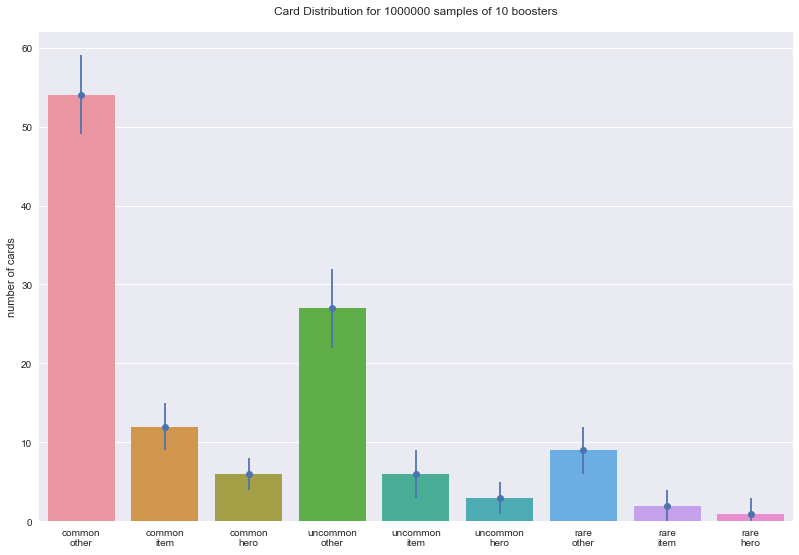

In [16]:
data = (card_distribution
        .assign(combo_str=lambda df: df["rarity"] + "\n" + df["category"]))

hpdi = np.abs(data["mean"].values.reshape(-1, 1) - data[["lower", "upper"]].values).T

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.barplot(ax=ax, data=data, x="combo_str", y="mean")
ax.errorbar(data["combo_str"], data["mean"], fmt="o", yerr=hpdi)

ax.set_title("Card Distribution for {} samples of 10 boosters\n".format(NUM_SAMPLES, NUM_BOOSTERS))
ax.set_ylabel("number of cards")
ax.set_xlabel("");

## Expected Prices

Using the card distribution, I can build the expected price distribution based on the prices of each `rarity-category` on the market.

#### Market Prices

In [17]:
# Collecting all market prices by `rarity-category`
combo_prices = (market
                .merge(all_cards, on="name")
                .assign(rarity=lambda df: df["rarity"].str.lower())
                .assign(category=lambda df: df["category"].str.lower())
                .assign(category=lambda df: np.where(df["category"].isin(category_key.keys()),
                                                     df["category"],
                                                     "other"))
                .merge(card_keys.reset_index(), on=["rarity", "category"])
                .groupby(["combo_key", "rarity", "category"])
                .agg({"price": list,
                      "name": "count"})
                .rename(columns={"name": "count"})
                .reset_index(level=[1, 2])
                .loc[card_keys.index])
combo_prices

,rarity,category,price,count
combo_key,,,,
5,common,other,"[2.11, 2.3, 2.23, 2.2, 2.14, 1.9, 2.25, 2.12, ...",48
7,common,item,"[2.18, 1.9, 2.07, 2.27, 2.22, 2.13, 2.15, 2.19...",14
11,common,hero,"[2.22, 2.48, 2.57, 2.55, 2.24, 2.64, 2.48, 2.2...",20
10,uncommon,other,"[2.53, 2.08, 2.21, 2.96, 2.12, 2.23, 3.37, 2.4...",52
14,uncommon,item,"[2.53, 92.55, 12.82, 2.19, 5.07, 2.54, 2.41, 2...",14
22,uncommon,hero,"[2.12, 13.35, 6.52, 2.48, 2.88, 2.42, 3.75, 7....",12
15,rare,other,"[475.3, 211.79, 65.11, 8.22, 15.83, 6.51, 4.8,...",52
21,rare,item,"[58.88, 9.71, 6.86, 159.01, 6.37, 14.16, 6.4, ...",13
33,rare,hero,"[914.83, 45.02, 50.02, 674.14, 63.16, 360.21, ...",12


#### Price Matrix

Creating a $9 \times \text{max}(\mathit{count})$ matrix padded with 0s for more efficient price sampling

In [18]:
max_count = combo_prices["count"].max()

acc = []
for idx in card_keys.index:
    idx_prices = combo_prices.loc[idx]["price"]
    idx_padding = max_count - combo_prices.loc[idx]["count"]
    idx_padded = np.pad(idx_prices, (0, idx_padding), "constant")
    acc.append(idx_padded)
price_matrix = np.vstack(acc)

print(price_matrix.shape)
price_matrix[0:3, 0:3]

(9, 52)


array([[2.11, 2.3 , 2.23],
       [2.18, 1.9 , 2.07],
       [2.22, 2.48, 2.57]])

#### Sample Prices

In [19]:
# The Poisson lambda for each draw should be number_of_items/number_of_prices, 
# This approximates drawing from prices, uniformly and with replacement.

samples_lambda = samples/combo_prices["count"].values

# For each sample, draw a price from the poisson and sum the result

acc = []
for sample_lambda in samples_lambda:
    sample_draws = stats.poisson.rvs(np.tile(samples_lambda[0], (max_count, 1)).T)
    sample_price = np.sum(sample_draws * price_matrix)
    acc.append(sample_price)

samples_price = np.array(acc)
print(samples_price.shape)
samples_price[:3]

(1000000,)


array([1494.52, 1186.19,  802.15])

### Probability of Breaking Even

To each price, I'll add the prices of the sold starter cards and reduce the whole thing by 15% (Valve's Cut)

In [20]:
starter_price = (sellable_starters
                 .merge(market, on="name")
                 .assign(total=lambda df: df["price"] * df["quantity"])
                 ["total"]
                 .sum())
starter_price

131.26

In [21]:
samples_income = (samples_price + starter_price) * 0.85
print(samples_income.shape)
samples_income[:3]

(1000000,)


array([1381.913 , 1119.8325,  793.3985])

The current price of Artifact is 1499 INR, therefore I'm looking for $P(\mathit{income} \ge 1499)$

In [22]:
print("P(income > 1499) =", (samples_income > 1499).sum()/NUM_SAMPLES)

P(income > 1499) = 0.26379


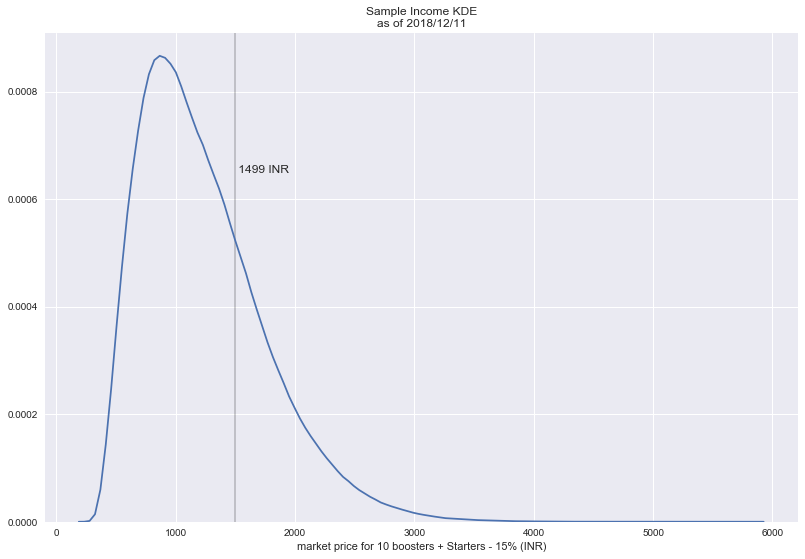

In [23]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(samples_income)
ax.vlines(1499, 0, 0.002, alpha=0.2)
ax.text(1499, 0.00065, " 1499 INR")
ax.set_title("Sample Income KDE\n"
             "as of 2018/12/11")
ax.set_xlabel("market price for 10 boosters + Starters - 15% (INR)");

## Conclusion

In [24]:
mu = samples_income.mean()
(lb, ub) = np.percentile(samples_income, [5.5, 94.5])
break_even = (samples_income > 1499).sum()/NUM_SAMPLES * 100
pd.DataFrame([[mu, lb, ub, break_even]], 
             columns=["Mean", "5.5%", "94.5%", "break even %"],
             index=["Summary"]).round(2).T

,Summary
Mean,1227.04
5.5%,566.24
94.5%,2180.66
break even %,26.38
